# Project 2 

The framework should import only torch.empty, and use no pre-existing neural-network python toolbox. Your code should work with autograd globally off, which can be achieved with torch . set˙grad˙enabled ( False )

In [1]:
import math
import torch 
torch.set_grad_enabled(False)

### Build the data

Generates a training and a test set of 1, 000 points sampled uniformly in [0, 1]², each with a label 0 if outside the disk centered at (0.5, 0.5) of radius 1/sqrt(2π), and 1 inside.

In [2]:
def build_data(n):
       
    x = torch.empty(n, 2) #(n,2)
    x = x.uniform_(0, 1)
    
    x_centered = x - 0.5
    norm_squared = x_centered.pow(2).sum(dim=1)  #(n,)
    
    r_squared = 1/ (2*math.pi)
    
    y = norm_squared.sub(r_squared).sign().add(1).div(2)
    return x, y

In [3]:
X_train, y_train = build_data(1000)  #(1000,2) , #(1000)
X_test, y_test = build_data(1000)  #(1000,2) , #(1000)

In [4]:
x = X_train[:,0]
y = X_train[:,1]
colors = { 1.0 : 'g', 0 : 'y'}

In [5]:
c = [ colors[label] for label in y_train.numpy()]

In [6]:
def one_hot_encoding(target):
    encoded = torch.empty(target.shape[0], 2)
    for i in range(target.shape[0]): 
        if(target[i]):
            encoded[i,0] = 0
            encoded[i,1] = target[i]
        else : 
            encoded[i,0] = 1
            encoded[i,1] = target[i]
    return encoded

In [7]:
encoded_y_train = one_hot_encoding(y_train)
encoded_y_test = one_hot_encoding(y_test)

### Visualize the data

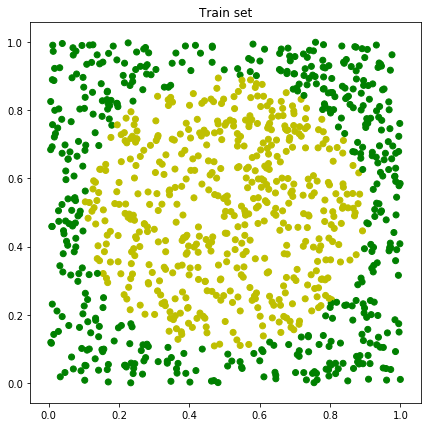

In [8]:
import matplotlib.pyplot as plt  # This is python's popular plotting library.

plt.figure(figsize=(7,7))
plt.scatter(x, y, c = c)
plt.title('Train set')
plt.show()

### Build the network

In [9]:
from linear import Linear
from activation_function.tanh import Tanh
from activation_function.sigmoid import Sigmoid
from sequential import Sequential
from optimizer.sgd import SGD
from loss.mse import MSELoss
from activation_function.relu import ReLU
from activation_function.leakyReLu import LeakyReLU

In [10]:
input_units = 2
hidden_units = 25
output_units = 2

model = Sequential(
            Linear(input_units, hidden_units),
            LeakyReLU(),
            Linear(hidden_units, hidden_units),
            LeakyReLU(),
            Linear(hidden_units, hidden_units),
            LeakyReLU(),
            Linear(hidden_units, output_units),
            Sigmoid()
)

In [11]:
def train_model(model, X_train, y_train, epochs, mini_batch_size , lr = 0.01):
    
    total_loss = []
    
    criterion = MSELoss(model)
    optimizer = SGD(model, lr)
    
    #one hot encoding 
    encoded_y_train = one_hot_encoding(y_train)
    
    number_batches =  X_train.size(0) // mini_batch_size
    
    for epoch in range(epochs):
        
        loss_epoch = 0
        
        for index in range(0, X_train.size(0), mini_batch_size):
            X_train_batched = X_train[index:(index+mini_batch_size)]
            y_train_batched = encoded_y_train[index:(index+mini_batch_size)]
            
            #forward pass
            output = model.forward(X_train_batched)
            loss = criterion.forward(output, y_train_batched)
            loss_epoch += loss.item() 
                     
            #backward pass and update parameters gradient
            criterion.backward()  
            #update parameters
            optimizer.step()
        
        total_loss.append(loss_epoch / number_batches)
        
    return model, total_loss

In [12]:
epochs = 25
mini_batch_size = 5
model_trained, loss_epoch =  train_model(model, X_train, y_train, epochs, mini_batch_size , lr = 0.1)

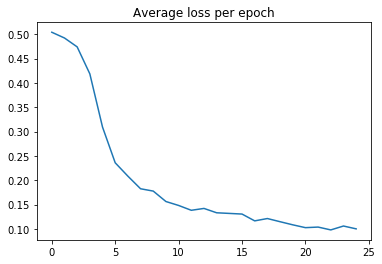

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_epoch)
plt.title('Average loss per epoch')
plt.show()

## Pytorch

In [14]:
import torch.nn as nn

torch.set_grad_enabled(True)

model_torch = nn.Sequential(
            nn.Linear(input_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_units),
            nn.Sigmoid()
)

In [15]:
def train_model(model, train_input, train_target, mini_batch_size):
    criterion = nn.MSELoss()
    eta = 1e-1

    for e in range(25):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            with torch.no_grad():
                for p in model.parameters():
                    #print(p)
                    p -= eta * p.grad
        print(e, sum_loss)

def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [16]:
#one hot encoding 
encoded_y_train = one_hot_encoding(y_train)

In [17]:
train_model(model_torch, X_train, encoded_y_train, 5)

0 50.09885463118553
1 49.97575908899307
2 49.932758033275604
3 49.877287939190865
4 49.79895304143429
5 49.68132871389389
6 49.495761439204216
7 49.17893382906914
8 48.584803342819214
9 47.38671572506428
10 44.8191382586956
11 39.6062840744853
12 31.22533468529582
13 23.285576450638473
14 19.251104830531403
15 16.832403745385818
16 15.459504192578606
17 14.291293788526673
18 13.67425142036518
19 13.146038077888079
20 12.612304125941591
21 11.844548056469648
22 12.243343208814622
23 10.92547248043411
24 10.914632342610275
